In [1]:
# data analysis
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pyampute.exploration.md_patterns import mdPatterns
from pyampute.exploration.mcar_statistical_tests import MCARTest

In [2]:
credit_risk_dataset = pd.read_csv(
    filepath_or_buffer = "../data/interim/credit_risk_dataset_prepped.csv"
)

In [3]:
credit_risk_dataset

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,False,0.10,False,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,True,0.57,False,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,True,0.53,False,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,True,0.55,True,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,True,0.25,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32404,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,False,0.11,False,30
32405,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,False,0.15,False,19
32406,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,True,0.46,False,28
32407,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,False,0.10,False,26


### Missing Values

#### Re-Identifying Missing Values

In [4]:
credit_risk_dataset.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3094
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [5]:
credit_risk_dataset.isna().sum()/len(credit_risk_dataset)

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027369
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095467
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

##### Features that contain NaNs are missing only less than 10% of their total data - no cause for dropping columns (albeit this step would have been performed in the EDA section)

In [6]:
credit_risk_dataset.isna().all(axis=1).sum()

0

In [7]:
credit_risk_dataset.isna().all(axis=0).sum()

0

##### There aren't any completely empty row or columns

### Missing Value Validations

#### MCAR

##### Identifying Missing Value Patterns

In [8]:
nan_dataset = credit_risk_dataset[["person_emp_length", "loan_int_rate"]]

In [9]:
mdp = mdPatterns()

c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\pyampute\exploration\md_patterns.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group_values = group_values.append(colsums, ignore_index=True)


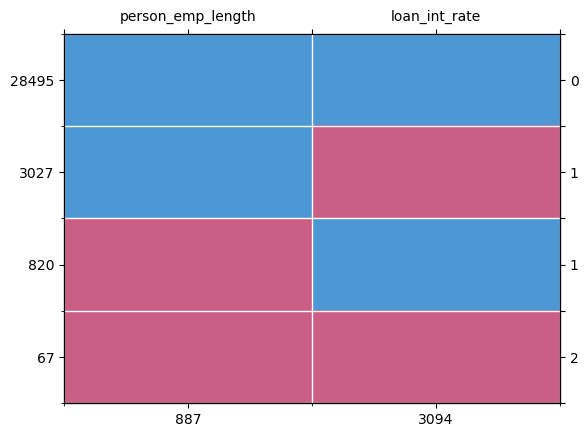

In [10]:
patterns = mdp.get_patterns(nan_dataset)

#### MCAR Testing

##### * Null Hypothesis: Data is MCAR
##### * Alternative Hypothesis: Data is not MCAR

In [11]:
mt_little = MCARTest(method="little")

In [12]:
numeric_dataset = credit_risk_dataset.select_dtypes(
    include=['int64', 'float64']
)

In [13]:
mt_little.little_mcar_test(
    X=numeric_dataset)

0.0

##### Reject the Null Hypothesis - The test determined the data is not MCAR; Its either MAR or MNAR.

### MAR Identification

In [14]:
credit_risk_dataset['PEL_Missing'] = credit_risk_dataset['person_emp_length'].isnull()

In [15]:
credit_risk_dataset

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,PEL_Missing
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,False,0.10,False,2,False
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,True,0.57,False,3,False
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,True,0.53,False,2,False
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,True,0.55,True,4,False
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,True,0.25,False,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32404,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,False,0.11,False,30,False
32405,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,False,0.15,False,19,False
32406,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,True,0.46,False,28,False
32407,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,False,0.10,False,26,False


In [16]:
numeric_features = credit_risk_dataset.select_dtypes(
    include=['int64', 'float64']).columns
numeric_features


Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

Text(0.5, 1.0, 'Missingness of PEL Relation to Personal Income')

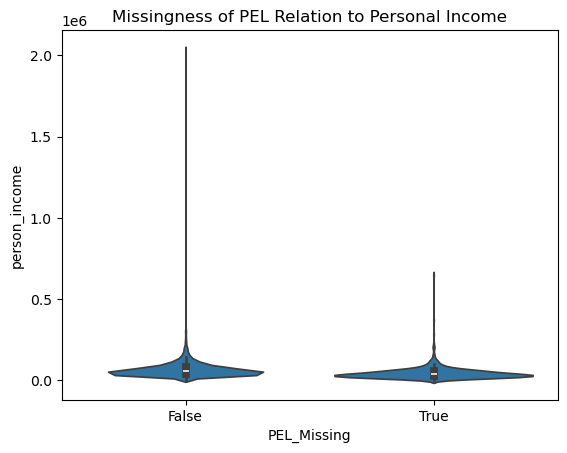

In [ ]:
sns.violinplot(
        x="PEL_Missing",
        y="person_income",
        data=credit_risk_dataset
    )
plt.title("Missingness of PEL related to Personal Income")

Text(0.5, 1.0, 'Missingness of PEL related to Loan Amount')

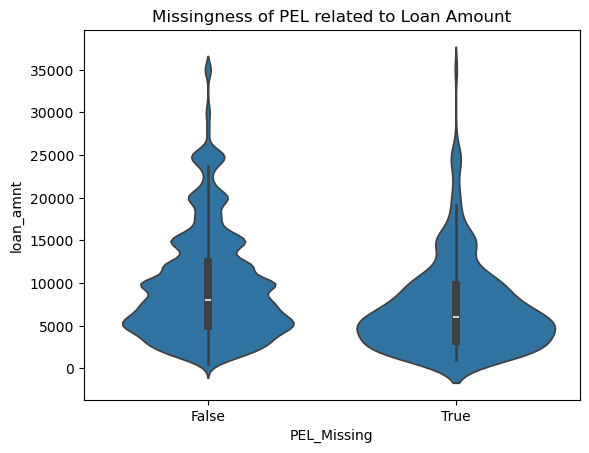

In [36]:
sns.violinplot(
        x="PEL_Missing",
        y="loan_amnt",
        data=credit_risk_dataset
        #ax=ax[0]
    )
plt.title("Missingness of PEL related to Loan Amount")